---
title: Parcel delineation using Sentinel-2
subtitle: Delineating agricultural parcels based on a neural network, using Sentinel-2 input data
authors:
  - name: Juraj Zvolenský
    orcid: 0009-0000-9185-7955
    github: jzvolensky
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Yuvraj Bhagwan Adagale
    orcid: 0009-0008-1259-3399
    github: Yuvraj198920
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-06-13
thumbnail: ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
keywords : ["xarray", "Sentinel-2", "parcel delineation", "neural network", "remote sensing"]
tags: ["xarray", "Machine Learning", "Sentinel-2", "Neural Networks"]
releaseDate: 2025-06-13
datePublished: 2025-06-13
dateModified: 2025-06-13
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Preface](#Preface_ONNX)
- [Introduction](#Introduction_ONNX)
- [Setup](#Setup_ONNX)
- [Find required data](#Find-required-data_ONNX)
- [Read EOPF Zarr](#Read-EOPF-Zarr_ONNX)
- [Select, validate, and apply mask](#Select,-validate,-and-apply-mask_ONNX)
- [Calculate NDVI](#Calculate-NDVI_ONNX)
- [Download neural networks](#Download-neural-networks_ONNX)
- [Run segmentation over NDVI](#Run-segmentation-over-NDVI_ONNX)
- [Visualize results](#Visualize-results_ONNX)

(Preface_ONNX)=
## Preface

The original notebook used as a starting point for this work is a Copernicus Data Space Ecosystem example, [available here](https://documentation.dataspace.copernicus.eu/APIs/openEO/openeo-community-examples/python/ParcelDelineation/Parcel%20delineation.html), originally created by VITO (see the CDSE notebook for the original authors).  
The example has been adapted to use the data provided by the EOPF Zarr Samples project instead of the openEO API.

(Introduction_ONNX)=
## Introduction

In this notebook we will be performing parcel delineation using Sentinel-2 Zarr data. The process involves reading the Sentinel-2 data, calculating the NDVI (Normalized Difference Vegetation Index), and applying a pre-trained neural network model to segment the parcels.

:::{hint} Overview
**Questions**
- How to access and filter Sentinel-2 Zarr data?
- How can I preprocess the data for parcel delineation?
- How can I apply a neural network for segmentation?

**Objectives**
- Query, access, and filter Sentinel-2 Zarr data.
- Calculate NDVI from Sentinel-2 data.
- Apply a neural network model to segment parcels.
:::

(Setup_ONNX)=
## Setup
Start importing the necessary libraries

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import s3fs
import xarray as xr
from distributed import LocalCluster
from pyproj import Transformer

from parcel_delineation_utils import apply_filter, apply_segmentation_parallel

In [ ]:
cluster = LocalCluster(processes=False)
client = cluster.get_client()
cluster

/home/mclaus@eurac.edu/micromamba/envs/eopf-zarr/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33465 instead
  warnings.warn(


LocalCluster(707ca412, 'inproc://10.8.244.129/1231331/1', workers=1, threads=16, memory=62.80 GiB)

Time difference is not larger than a week for good parcel delineation
Time difference is not larger than a week for good parcel delineation
Time difference is not larger than a week for good parcel delineation
Time difference is not larger than a week for good parcel delineation
Time difference is not larger than a week for good parcel delineation
Time difference is not larger than a week for good parcel delineation
Time difference is not larger than a week for good parcel delineation
Time difference is not larger than a week for good parcel delineation
Time difference is not larger than a week for good parcel delineation


(find-required-data_ONNX)=
## Find required data

In [3]:
bucket = "e05ab01a9d56408d82ac32d69a5aae2a:sample-data"
prefix = "tutorial_data/cpm_v253/"
# Create the S3FileSystem with a custom endpoint
fs = s3fs.S3FileSystem(
    anon=True, client_kwargs={"endpoint_url": "https://objectstore.eodc.eu:2222"}
)

# unregister handler to make boto3 work with CEPH
handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
handler_to_unregister = handlers_to_unregister[0]
fs.s3.meta.events._emitter.unregister(
    "before-parameter-build.s3", handler_to_unregister
)

s3path = "s3://" + f"{bucket}/{prefix}" + "S2*_MSIL2A_*_*_*_T31UFS_*.zarr"
remote_files = fs.glob(s3path)
prefix = "https://objectstore.eodc.eu:2222"
paths = [f"{prefix}/{f}" for f in remote_files]

print(len(paths))

12


(Read-EOPF-Zarr_ONNX)=
## Read EOPF Zarr

In this step, we read the Zarr data and perform spatial filtering. Then we open the 10 meter band data as well as the SCL, which we will use for cloud masking.


In [4]:
ds = xr.open_datatree(paths[0], engine="zarr", chunks={}, decode_timedelta=False)
target_crs = ds.attrs["stac_discovery"]["properties"]["proj:epsg"]
print(f"Target CRS of the selected Sentinel-2 tiles: {target_crs}")

spatial_extent = {
    "west": 5.0,
    "south": 51.2,
    "east": 5.1,
    "north": 51.3,
}
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32631", always_xy=True)
west_utm, south_utm = transformer.transform(
    spatial_extent["west"], spatial_extent["south"]
)
east_utm, north_utm = transformer.transform(
    spatial_extent["east"], spatial_extent["north"]
)

x_slice = slice(west_utm, east_utm)
y_slice = slice(north_utm, south_utm)


def extract_time_and_crop(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    ds = ds.assign_coords(time=time)
    return ds.sel(x=x_slice, y=y_slice)

Target CRS of the selected Sentinel-2 tiles: 32631


In [5]:
r10m = xr.open_mfdataset(
    paths,
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r10m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time_and_crop,
    decode_cf=False,
    mask_and_scale=False,
)

scl = xr.open_mfdataset(
    paths,
    engine="zarr",
    chunks={},
    group="conditions/mask/l2a_classification/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time_and_crop,
    decode_cf=False,
    mask_and_scale=False,
)

r10m.rio.write_crs(target_crs, inplace=True)
r10m = r10m.sortby("time")

scl.rio.write_crs(target_crs, inplace=True)
scl = scl.sortby("time")

r10m

<xarray.Dataset> Size: 72MB
Dimensions:      (time: 12, y: 1131, x: 667)
Coordinates:
  * x            (x) int64 5kB 639735 639745 639755 ... 646375 646385 646395
  * y            (y) int64 9kB 5685275 5685265 5685255 ... 5673985 5673975
  * time         (time) datetime64[ns] 96B 2021-02-09T10:51:09 ... 2021-09-07...
    spatial_ref  int64 8B 0
Data variables:
    b02          (time, y, x) uint16 18MB dask.array<chunksize=(1, 358, 667), meta=np.ndarray>
    b03          (time, y, x) uint16 18MB dask.array<chunksize=(1, 358, 667), meta=np.ndarray>
    b04          (time, y, x) uint16 18MB dask.array<chunksize=(1, 358, 667), meta=np.ndarray>
    b08          (time, y, x) uint16 18MB dask.array<chunksize=(1, 358, 667), meta=np.ndarray>

(select-validate-and-apply-mask_ONNX)=
## Select, validate, and apply mask

Here we prepare and interpolate the mask to align with the 10 meters bands, so that we can apply it over the data.

In [6]:
def validate_scl(scl):
    invalid = [0, 1, 3, 7, 8, 9, 10]  # NO_DATA, SATURATED, CLOUD, etc.
    return ~scl.isin(invalid)


mask_scl_r10m = scl.scl.chunk(chunks={"x": -1, "y": -1}).interp(
    x=r10m["x"], y=r10m["y"], method="nearest"
)

valid_mask = validate_scl(mask_scl_r10m)
masked = r10m.where(valid_mask)
masked

<xarray.Dataset> Size: 145MB
Dimensions:      (time: 12, y: 1131, x: 667)
Coordinates:
  * x            (x) int64 5kB 639735 639745 639755 ... 646375 646385 646395
  * y            (y) int64 9kB 5685275 5685265 5685255 ... 5673985 5673975
  * time         (time) datetime64[ns] 96B 2021-02-09T10:51:09 ... 2021-09-07...
    spatial_ref  int64 8B 0
Data variables:
    b02          (time, y, x) float32 36MB dask.array<chunksize=(1, 358, 667), meta=np.ndarray>
    b03          (time, y, x) float32 36MB dask.array<chunksize=(1, 358, 667), meta=np.ndarray>
    b04          (time, y, x) float32 36MB dask.array<chunksize=(1, 358, 667), meta=np.ndarray>
    b08          (time, y, x) float32 36MB dask.array<chunksize=(1, 358, 667), meta=np.ndarray>

(calculate-ndvi_ONNX)=
## Calculate NDVI

In this step, we calculate NDVI using the masked data as input. The resulting NDVI will be used for running the inference.

We also save the NDVI data to a local Zarr, as this makes it more efficient when running the inference. 

In [7]:
def calculate_ndvi(ds: xr.Dataset) -> xr.DataArray:
    """Calculate NDVI from dataset with B04 and B08"""
    red = (ds["b04"] * ds["b04"].attrs["_eopf_attrs"]["scale_factor"]) + ds[
        "b04"
    ].attrs["_eopf_attrs"]["add_offset"]

    nir = (ds["b08"] * ds["b08"].attrs["_eopf_attrs"]["scale_factor"]) + ds[
        "b08"
    ].attrs["_eopf_attrs"]["add_offset"]

    return (nir - red) / (nir + red)


ndvi = calculate_ndvi(masked)
ndvi

<xarray.DataArray (time: 12, y: 1131, x: 667)> Size: 36MB
dask.array<truediv, shape=(12, 1131, 667), dtype=float32, chunksize=(1, 773, 667), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) int64 5kB 639735 639745 639755 ... 646375 646385 646395
  * y            (y) int64 9kB 5685275 5685265 5685255 ... 5673985 5673975
  * time         (time) datetime64[ns] 96B 2021-02-09T10:51:09 ... 2021-09-07...
    spatial_ref  int64 8B 0

Visualize a sample date for NDVI

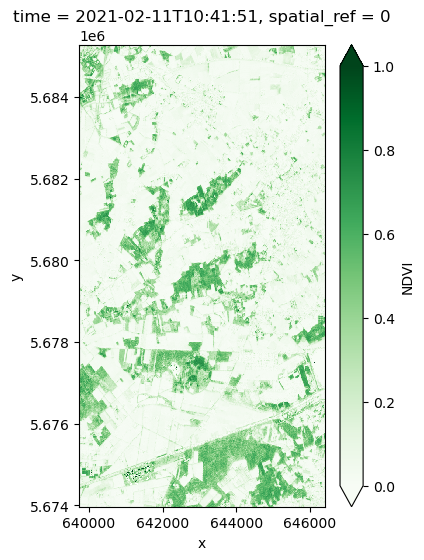

In [8]:
ndvi.isel(time=1).plot.imshow(
    cmap="Greens",
    vmin=0,
    vmax=1,
    aspect=0.66,
    size=6,
    add_colorbar=True,
    cbar_kwargs={"label": "NDVI"},
)

In [9]:
# Save the NDVI to Zarr to speed up inference
ndvi_rechunked = ndvi.chunk({"time": 4, "y": 400, "x": 667})

ndvi_rechunked.name = "NDVI"
ndvi_rechunked = ndvi_rechunked.to_dataset()

ndvi_rechunked.to_zarr("ndvi.zarr", mode="w", consolidated=True)

(download-neural-networks_ONNX)=
## Download neural networks
Here we download and the pretrained neural networks used for parcel delineation. The networks are downloaded to a local directory, so that we can use them for inference.

In [10]:
models_url = "https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/openeo/parcelDelination/BelgiumCropMap_unet_3BandsGenerator_Models.zip"

os.system(f"wget {models_url} -O models.zip")
os.system("unzip -o models.zip -d onnx_models")
os.system("rm models.zip")

--2025-06-16 15:57:58--  https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/parcelDelination/BelgiumCropMap_unet_3BandsGenerator_Models.zip
Resolving artifactory.vgt.vito.be (artifactory.vgt.vito.be)... 193.191.168.21
Connecting to artifactory.vgt.vito.be (artifactory.vgt.vito.be)|193.191.168.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85799844 (82M) [application/zip]
Saving to: ‘models.zip’

     0K .......... .......... .......... .......... ..........  0% 1.16M 71s
    50K .......... .......... .......... .......... ..........  0% 1.25M 68s
   100K .......... .......... .......... .......... ..........  0% 1.19M 68s
   150K .......... .......... .......... .......... ..........  0% 34.2M 52s
   200K .......... .......... .......... .......... ..........  0% 10.8M 43s
   250K .......... .......... .......... .......... ..........  0% 1.29M 46s
   300K .......... .......... .......... .......... ..........  0% 36.1M 40s
   350K .........

Archive:  models.zip
  inflating: onnx_models/BelgiumCropMap_unet_3BandsGenerator_Network1.onnx  
  inflating: onnx_models/BelgiumCropMap_unet_3BandsGenerator_Network2.onnx  
  inflating: onnx_models/BelgiumCropMap_unet_3BandsGenerator_Network3.onnx  


0

(run-segmentation-over-ndvi_ONNX)=
## Run segmentation over NDVI

In the `parcel_delineation_utils.py` file, we have prepared the code that needs to be run for the inference. We simply open the NDVI data, and apply the neural networks to it.

After running the inference, we need to transpose the data, so that it is oriented correctly.


In [11]:
ndvi = xr.open_zarr("ndvi.zarr", consolidated=True)
ndvi = ndvi["NDVI"]
# Run the segmentation model
result = apply_segmentation_parallel(ndvi)

2025-06-16 15:58:14.682608751 [W:onnxruntime:Default, upsamplebase.h:178 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute
2025-06-16 15:58:14.682643832 [W:onnxruntime:Default, upsamplebase.h:178 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute
2025-06-16 15:58:14.682653762 [W:onnxruntime:Default, upsamplebase.h:178 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute
2025-06-16 15:58:14.731915899 [W:onnxruntime:Default, upsamplebase.h:178 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute
2025-06-16 15:58:14.731943060 [W:onnxruntime:Default, upsamplebase.h:178 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute
2025-06-16 15:58:14.731950000 

Store the result as a netCDF

In [12]:
result = result.transpose(..., "y", "x")
result.to_dataset(dim="bands").to_netcdf("segmentation_result_parallel.nc")

(visualize-results_ONNX)=
## Visualize results

We present two different visualizations of the results. First one is a simple black and white plot of the results. The second is a segmentation used to highlight and delineate the parcels.

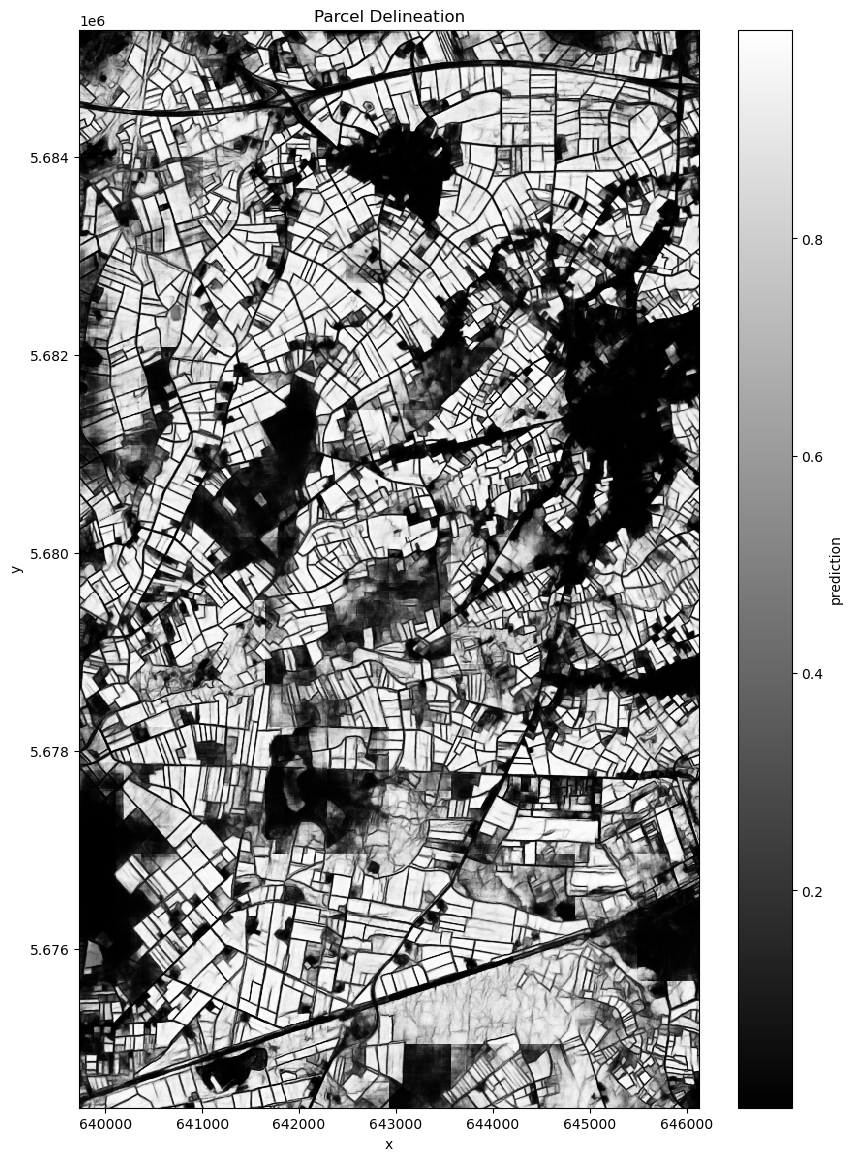

In [13]:
ds = xr.open_dataset("segmentation_result_parallel.nc")

ds.prediction.plot(figsize=(10, 14), cmap="gray")  # Use a colormap that suits your data
plt.title("Parcel Delineation")
plt.show()

## Close the dataset
ds.close()

Dimensions of the final datacube ('time', 'y', 'x')


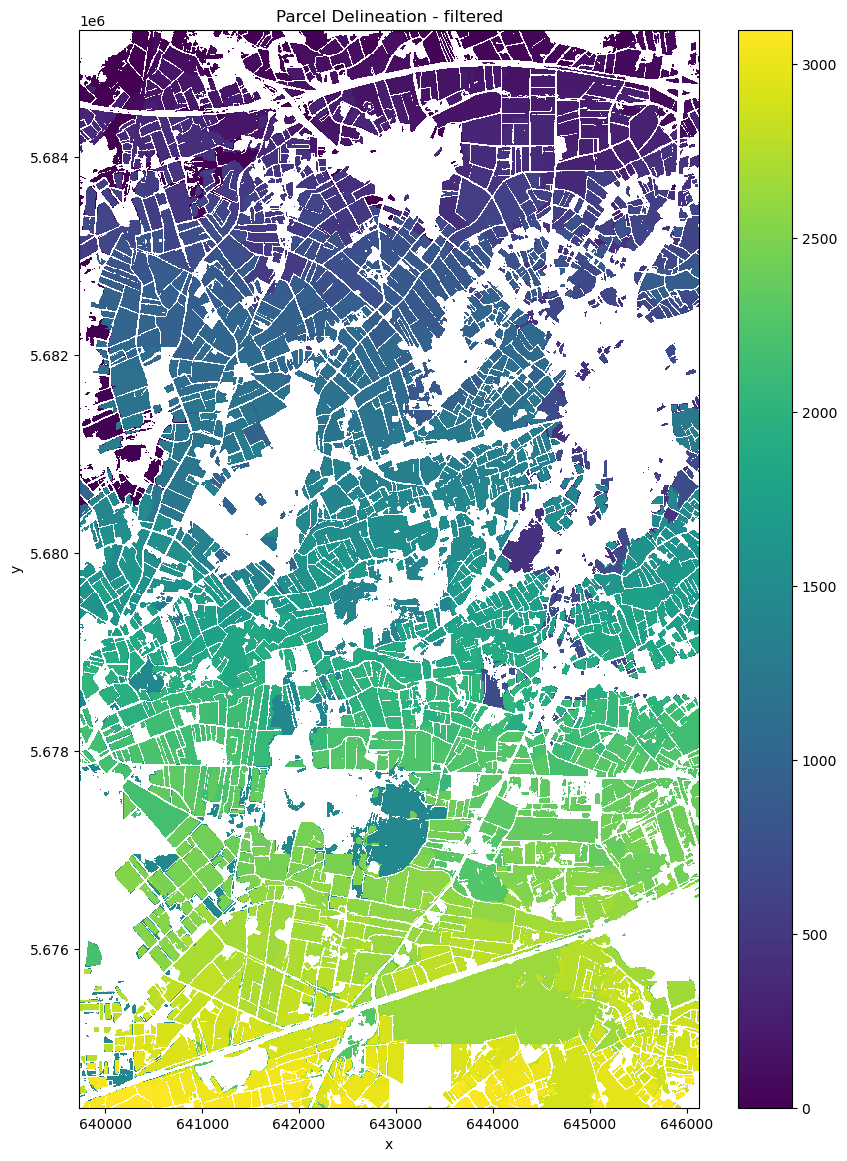

In [ ]:
filtered = apply_filter(cube=ds.prediction, context={})

# Store the filtered result locally as netCDF
filtered.name = "parcels"
filtered.to_dataset().to_netcdf("segmentation_filtered")

## Plot the data
filtered.plot(figsize=(10, 14), cmap="viridis")  # Use a colormap that suits your data
plt.title("Parcel Delineation - filtered")
plt.show()

## Close the dataset
ds.close()

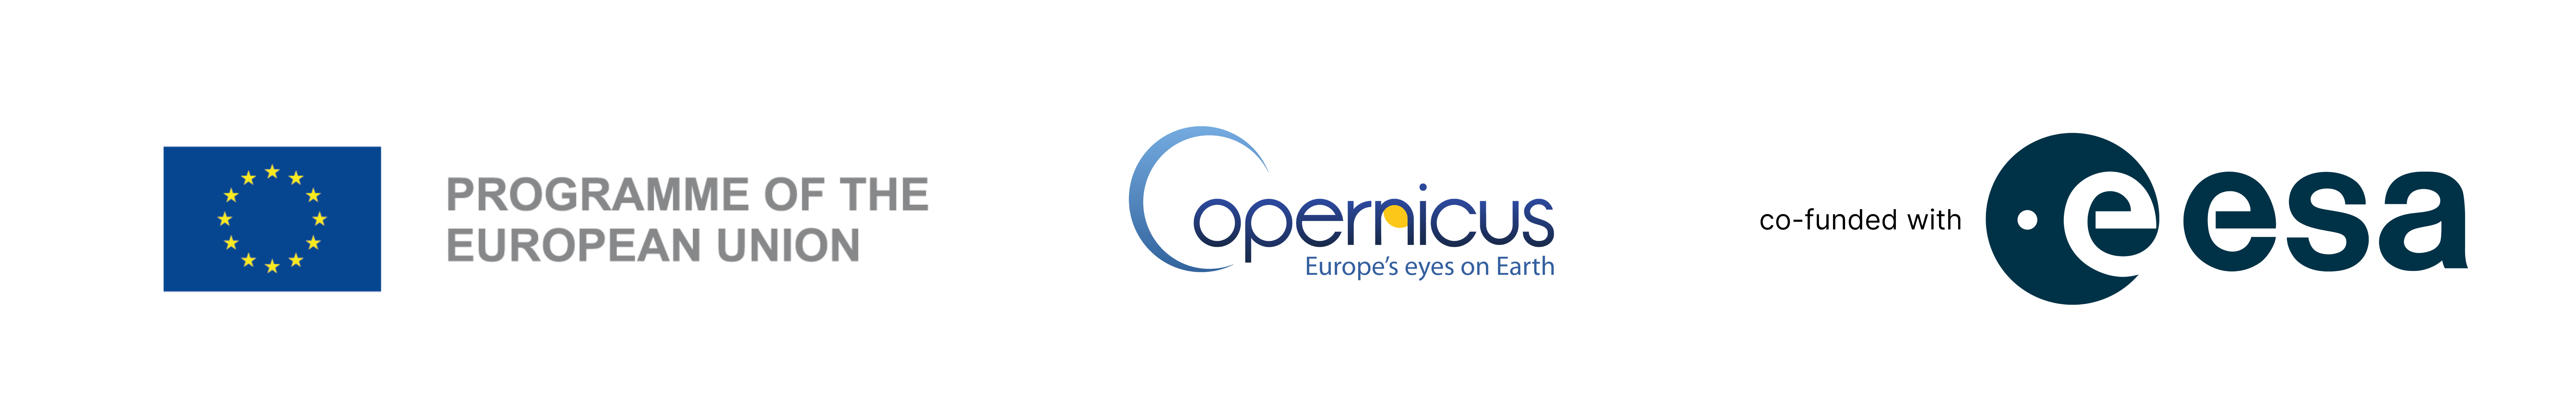